<h1>🎓 Trabajo Integrador Final</h1>

<h2>Integrantes</h2>
<ul>
  <li></li>
  <li></li>
  <li>Evers Juan Segundo</li>
  <li>Kelechian Leonardo</li>
</ul>

<h2>Introducción</h2>
<p>[...]</p>

<hr>

<h3>Importamos las librerias que usaremos durante el proyecto</h3>

In [1]:
# Conexión con Google Drive
# from google.colab import drive
# import os

# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np


import pickle

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Análisis Estadísticos
from scipy import stats

# PreProcesado y modelado
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import balanced_accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, average_precision_score

<h3>Conectamos Google Drive y cargamos el dataset</h3>

In [2]:
# drive.mount('/content/drive')

In [2]:
# elegir la carpeta donde estan las bases de datos:
# ruta_base = "/content/drive/MyDrive/"
# ruta_laboratorio = os.path.join(ruta_base, "Laboratorio de Ciencia de Datos")
# ruta_bases_datos = os.path.join(ruta_laboratorio, "Bases de Datos")

# # elegir la base de datos que quiero usar:
# ruta_archivo = os.path.join(ruta_bases_datos, "Grupo 3 - Abandono de Clientes.csv")
ruta_archivo = "data/Grupo 3 - Abandono de Clientes.csv"

In [3]:
#Cargar el dataset
data = pd.read_csv(ruta_archivo, sep=',', encoding='utf-8')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
#Hacemos una primera vista a nuestros datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


##⚙️ Preparación de los datos

<b><h3>Limpieza de datos<h3>

Antes de arrancar, tenemos que corroborar que los datos se encuentren limpios de forma tal que no afecten negativamente al modelo.

Luego de realizar un pequeño análisis univariado a las columnas de nuestro data set, encontramos que la columna `TotalCharges` era de tipo *object* cuando esta debería ser *float*. Entonces, la casteamos y encontramos también que escondía un par de valores nulos.

In [5]:
# Crear una copia del DataFrame para no modificar el original
df_mod = data.copy()

# Convertir TotalCharges a tipo numérico (float) y manejar errores
df_mod['TotalCharges'] = pd.to_numeric(df_mod['TotalCharges'], errors='coerce')

# Revisar valores faltantes o nulos en TotalCharges
print(f"Cantidad de filas con valor nulo en 'Total Charges': {df_mod['TotalCharges'].isnull().sum()}");


Cantidad de filas con valor nulo en 'Total Charges': 11


Como vemos, ahora existen 11 filas con valor nulo en esta variable. Si bien no son muchos valores, podríamos eliminarlos y es posible que el resultado final no varíe tanto, pero, decidimos que con el propósito de mantener todos los datos originales, se realizará una **Imputación por la mediana**.


In [6]:
# Eliminamos las filas con valores nulos en TotalCharges
df_mod = df_mod.dropna(subset=['TotalCharges'])
print(f"Cantidad de filas después de eliminar nulos: {len(df_mod)}")
print(f"Filas eliminadas: {len(data) - len(df_mod)}")

Cantidad de filas después de eliminar nulos: 7032
Filas eliminadas: 11


Ahora si, la variable `TotalCharges` ya se encuentra en el tipo de dato correcto y con sus valores nulos tratados.

Luego, el resto de las variables del dataset no requieren ningún cambio de tipo de dato, limpieza o tratamiento de outliers.

---


## 🔎 Busqueda de Modelo Base

Realizamos entrenamiento de modelos varios para ver cual elegimos y así realizar una busqueda de hiperparámetros

Hay que tener cuidado con esto ya que hay modelos que no necesitan estandarizacion como:

- Árboles de decisión
- Random Forest
- Gradient Boosting (XGBoost, LightGBM, HistGradientBoosting)

Pero luego los siguientes modelos si necesitan estandarización:
- Regresión Logística
- SVM (especialmente con kernel RBF o polinómico)

Entonces…
- Las métricas de SVM y Regresión Logística ahora son confiables hasta cierto punto, pero probablemente mejorarían con los datos estandarizados.

- Es posible que SVM con RBF haya rendido tan mal justamente por esto.

Por ende, dividiremos esta busqueda en dos fases:
- Comparación rápida sin procesar -> Donde solo confiaremos en las métricas de los modelos de árboles
- Comparación con estandarización -> Usaremos la misma función pero solo con los modelos sensibles a las escalas y el data set previamente estandarizado

Por ultimo, compararemos resultados.

### 🔍 Fase 1 - Comparación rápida sin procesar

In [9]:
#Esta función agarraria la BBDD sin realizar transformaciones y luego nos devuelve las métricas de cada modelo puesto
def evaluar_modelos(X_train, y_train, X_test, y_test):
    modelos = {
        #Estos son "tweaks iniciales seguros" que no se consideran tuning agresivo, sino buenas prácticas para establecer un baseline justo
        'Regresión Logística': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'HistGradientBoosting': HistGradientBoostingClassifier(),
        'XGBoost': XGBClassifier(eval_metric='logloss', scale_pos_weight=2.773, use_label_encoder=False), #scale_pos_weight = 'Churn' 73.5% (yes) / 26.5% (no) = 2.773
        'LightGBM': LGBMClassifier(verbose=-1, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
        'SVM_linear': SVC(kernel = 'linear', class_weight='balanced'),
        'SVM_rbf': SVC(kernel = 'rbf', class_weight='balanced')
    }

    resultados = []

    for nombre, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        # Asegurarse de que el modelo tiene el atributo predict_proba antes de usarlo
        if hasattr(modelo, "predict_proba"):
            y_proba = modelo.predict_proba(X_test)[:, 1]
        elif hasattr(modelo, "decision_function"):
            y_proba = modelo.decision_function(X_test)
        else:
            y_proba = None


        resultados.append({
            'Modelo': nombre,
            'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred), #Calcula el promedio de recall entre clases (recall clase 0 y clase 1).
            'F1 Score': f1_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred), #Indica cuántos de los que realmente se fueron (churn=1) tu modelo detectó.
            'Precision': precision_score(y_test, y_pred),
            # 'ROC AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None
            #PR AUC
            'PR AUC': average_precision_score(y_test,y_proba) if y_proba is not None else None #es más informativa cuando te interesa detectar bien la clase 1.
        })

    return pd.DataFrame(resultados).sort_values(by='Balanced Accuracy', ascending=False).reset_index(drop=True)

In [10]:
# Elimino costumerID
df_inicial = df_mod.copy()
df_inicial.drop(columns='customerID', inplace=True)

# Realizamos modificaciones rapidas porque nuestros modelos necesitan variables numericas
binary_cols_quick = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

# Variables categóricas con más de dos opciones (ajusta la lista si es necesario)
categorical_cols_quick = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                          'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                          'Contract', 'PaymentMethod']

# Aplicar codificación binaria a las columnas Yes/No
for col in binary_cols_quick:
    if col in df_inicial.columns:
        if df_inicial[col].dtype == 'object': # Solo codificar si son strings
             # Manejar el caso de 'No internet service' o 'No phone service' si aplica
            df_inicial[col] = df_inicial[col].replace({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})


# Aplicar One-Hot Encoding a las columnas con más de dos opciones
df_inicial = pd.get_dummies(df_inicial, columns=categorical_cols_quick, drop_first=True)

# Convertir las nuevas columnas booleanas a enteros (si pd.get_dummies las crea como bool)
bool_cols_quick = df_inicial.select_dtypes(include='bool').columns
df_inicial[bool_cols_quick] = df_inicial[bool_cols_quick].astype(int)

#Convertimos tambien la variable objetivo
df_inicial['Churn'] = df_inicial['Churn'].replace({'Yes': 1, 'No': 0})

# --- Fin de la codificación rápida ---




C:\Users\Leo\AppData\Local\Temp\ipykernel_4552\228888796.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_inicial[col] = df_inicial[col].replace({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})
C:\Users\Leo\AppData\Local\Temp\ipykernel_4552\228888796.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_inicial['Churn'] = df_inicial['Churn'].replace({'Yes': 1, 'No': 0})


In [11]:
# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        df_inicial.drop(columns = 'Churn'),
                                        df_inicial['Churn'],
                                        random_state = 22,
                                        test_size=0.25
                                    )

In [12]:
# Evaluamos los modelos inciales
# ==============================================================================
df_resultados = evaluar_modelos(X_train, y_train, X_test, y_test)
df_resultados

c:\Documentos\entornos\mi_entorno\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Documentos\entornos\mi_entorno\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:02:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Modelo,Balanced Accuracy,F1 Score,Recall,Precision,PR AUC
0,SVM_linear,0.755256,0.633628,0.733607,0.557632,0.642409
1,LightGBM,0.754522,0.634633,0.717213,0.569106,0.652196
2,Regresión Logística,0.750354,0.623638,0.762295,0.527660,0.649039
3,XGBoost,0.724792,0.598485,0.647541,0.556338,0.619064
4,HistGradientBoosting,0.697215,0.563218,0.502049,0.641361,0.638931
5,Random Forest,0.662669,0.503704,0.418033,0.633540,0.609118
6,SVM_rbf,0.621529,0.464738,0.526639,0.415858,0.505014


In [13]:
# #Guardo los resultados en un pickle
# with open('resultados_iniciales.pkl', 'wb') as f:
#     pickle.dump(df_resultados, f)

### Fase 2 - Comparación con estandarización

Utilizamos el mismo split de datos de antes...

In [14]:
# Variables a escalar
cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Inicializar el escalador
scaler = StandardScaler()

# Ajustar el escalador solo con datos de entrenamiento
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

Ajustamos la otra función para entrenar nuevamente pero sin los arboles...

In [15]:
def evaluar_modelos_estandarizados(X_train, y_train, X_test, y_test):
    modelos = {
        #Estos son "tweaks iniciales seguros" que no se consideran tuning agresivo, sino buenas prácticas para establecer un baseline justo
        'STD - Regresión Logística': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'STD - SVM_linear': SVC(kernel = 'linear', class_weight='balanced'),
        'STD - SVM_rbf': SVC(kernel = 'rbf', class_weight='balanced')
    }

    resultados = []

    for nombre, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        # Asegurarse de que el modelo tiene el atributo predict_proba antes de usarlo
        if hasattr(modelo, "predict_proba"):
            y_proba = modelo.predict_proba(X_test)[:, 1]
        elif hasattr(modelo, "decision_function"):
            y_proba = modelo.decision_function(X_test)
        else:
            y_proba = None


        resultados.append({
            'Modelo': nombre,
            'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred), #Calcula el promedio de recall entre clases (recall clase 0 y clase 1).
            'F1 Score': f1_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred), #Indica cuántos de los que realmente se fueron (churn=1) tu modelo detectó.
            'Precision': precision_score(y_test, y_pred),
            # 'ROC AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None
            #PR AUC
            'PR AUC': average_precision_score(y_test,y_proba) if y_proba is not None else None #es más informativa cuando te interesa detectar bien la clase 1.
        })

    return pd.DataFrame(resultados).sort_values(by='Balanced Accuracy', ascending=False).reset_index(drop=True)

In [16]:
# Evaluamos los modelos inciales
# ==============================================================================
df_resultados_std = evaluar_modelos_estandarizados(X_train_scaled, y_train, X_test_scaled, y_test)
df_resultados_std

,Modelo,Balanced Accuracy,F1 Score,Recall,Precision,PR AUC
0,STD - SVM_rbf,0.755836,0.632214,0.752049,0.545319,0.608107
1,STD - Regresión Logística,0.750986,0.624268,0.764344,0.527581,0.647927
2,STD - SVM_linear,0.738570,0.604900,0.809426,0.482885,0.621324


In [17]:
#Guardo los resultados en un pickle
# with open('resultados_iniciales_estandarizados.pkl', 'wb') as f:
#     pickle.dump(df_resultados_std, f)

---

###Comparación de resultados

In [18]:
df_resultados['Datos'] = 'Sin escalar'
df_resultados_std['Datos'] = 'Estandarizados'
df_todos = pd.concat([df_resultados, df_resultados_std], ignore_index=True)
df_todos_ordenado = df_todos.sort_values(by='Balanced Accuracy', ascending=False).reset_index(drop=True)

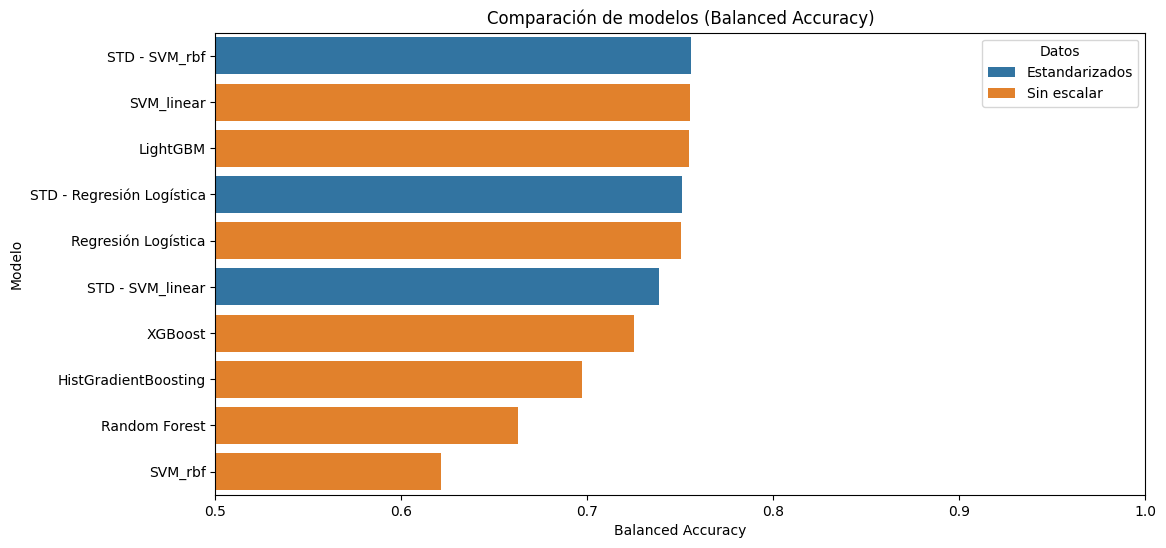

In [19]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_todos_ordenado, x='Balanced Accuracy', y='Modelo', hue='Datos')
plt.title('Comparación de modelos (Balanced Accuracy)')
plt.xlim(0.5, 1.0)  # si querés limitar el eje x para enfocar
plt.show()


<h3>Conclusión</h3>


* ✅ El modelo con mejor rendimiento general fue el `SVM_rbf` estandarizado, alcanzando la mayor Balanced Accuracy entre todos los modelos comparados.
* 🌳 El modelo `lightGBM` fue el que mejor accuracy tuvo de todos los árboles, teniendo casi el mismo valor que el SVM. Similar, solo por apenas debajo de este, se encuentra el de `Regresión Logística`. Ambos tambien podrían ser considerados como modelo final.
* ⚠️ El `SVM_linear` sin estandarizar puede no ser confiable, esto se debe a que luego de ser escalado, su accuracy es mucho menor, lo que nos hace pensar que en ese primer entrenamiento se vió sesgado por la escala de alguna variable.


Comparación de F1-Score y PR AUC para modelos seleccionados:
                      Modelo  F1 Score    PR AUC    Recall  Precision
1                   LightGBM  0.634633  0.652196  0.717213   0.569106
8  STD - Regresión Logística  0.624268  0.647927  0.764344   0.527581
7              STD - SVM_rbf  0.632214  0.608107  0.752049   0.545319


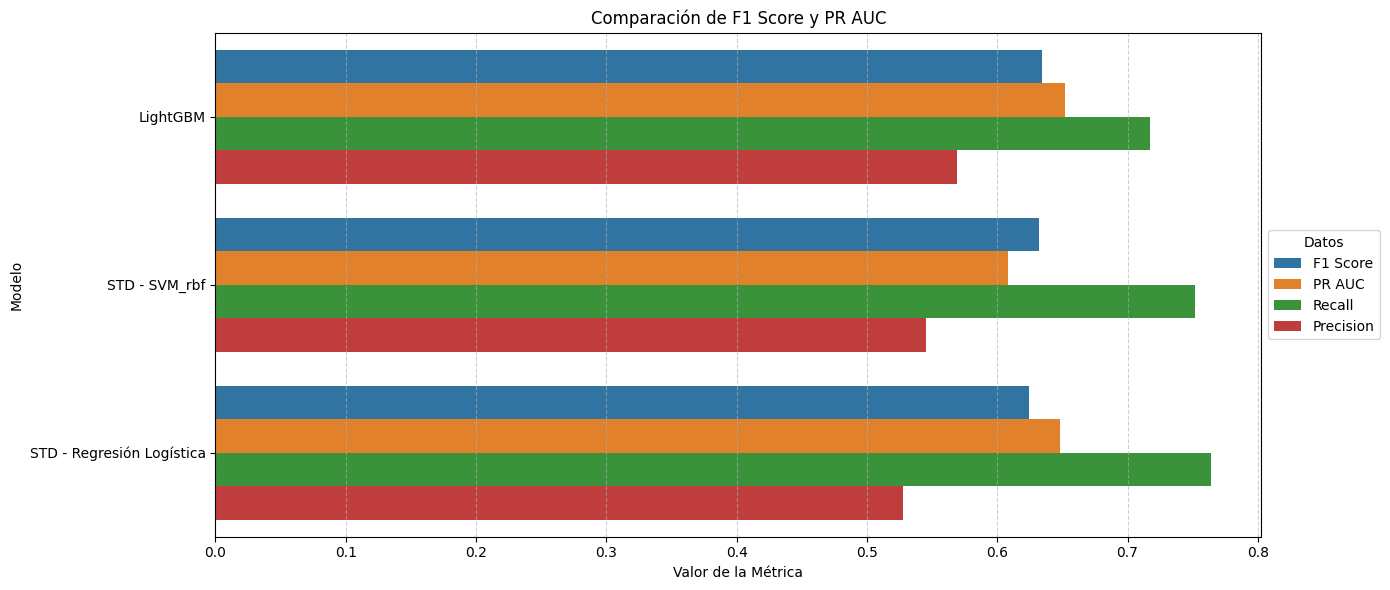

In [20]:
# Filtrar los resultados para los modelos específicos que quieres comparar
modelos_comparar = ['STD - SVM_rbf', 'LightGBM', 'STD - Regresión Logística']

# Crear un DataFrame combinado si aún no lo tienes
# Asumiendo que df_resultados y df_resultados_std ya existen del código anterior
# Si no, deberías ejecutarlos primero.
df_resultados['Datos'] = 'Sin escalar'
df_resultados_std['Datos'] = 'Estandarizados'
df_todos = pd.concat([df_resultados, df_resultados_std], ignore_index=True)

# Filtrar el DataFrame combinado para incluir solo los modelos deseados
df_comparacion_especifica = df_todos[df_todos['Modelo'].isin(modelos_comparar)]

# Seleccionar solo las columnas relevantes para la comparación de métricas
df_metricas_comparacion = df_comparacion_especifica[['Modelo', 'F1 Score', 'PR AUC','Recall','Precision']]

# Mostrar las métricas
print("Comparación de F1-Score y PR AUC para modelos seleccionados:")
print(df_metricas_comparacion.sort_values(by='PR AUC', ascending=False))

# Opcionalmente, puedes visualizar esta comparación
df_melted = df_metricas_comparacion.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')

plt.figure(figsize=(14, 6))
ax = sns.barplot(data=df_melted, x='Valor', y='Modelo', hue='Métrica')
plt.title('Comparación de F1 Score y PR AUC')
plt.xlabel('Valor de la Métrica')
plt.ylabel('Modelo')
# plt.legend(title='Métrica') # Elimina o comenta esta línea si usas ax.legend()
plt.grid(axis='x', linestyle='--', alpha=0.6)


ax.legend(title='Datos', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.show()


| Métrica                                       | ¿Qué mide?                                                                                       | ¿Por qué importa en tu caso?                                                                                            |
| --------------------------------------------- | ------------------------------------------------------------------------------------------------ | ----------------------------------------------------------------------------------------------------------------------- |
| **Balanced Accuracy**                         | Promedio de recall entre clase 0 y 1. No se deja engañar por el desbalance.                      | Te dice si el modelo aprende **ambas clases** en vez de acertar por casualidad.                                         |
| **Recall (o Sensibilidad)**                   | % de verdaderos positivos detectados. ¿Cuántos que realmente se fueron predijiste correctamente? | Es crítico: no querés dejar pasar clientes que se iban. Mejor tener falsos positivos que no detectarlos.                |
| **Precision**                                 | % de los que predijiste como "se va" que realmente se fueron.                                    | Complemento al recall. No querés alertar a todos si solo pocos se van.                                                  |
| **F1 Score**                                  | Promedio armonioso entre Precision y Recall.                                                     | Balance entre no asustar a todos y no perder a los que se iban.                                                         |
| **PR AUC (Área bajo curva Precision-Recall)** | Qué tan bien se comporta el modelo al clasificar la clase positiva.                              | Más útil que ROC AUC con clases desbalanceadas. Te da una idea del rendimiento **cuando te importa acertar positivos**. |


<h3>Conclusion final</h3>

Entonces, creo que el `LightGBM` porque, si bien no tiene el mayor recall (proporción de churners reales sí detectados), la precisión es la mas alta (de los que detectamos como churn, cuantos realmente lo eran). Esta ultima, si es baja, estaríamos "sobrealertando" o etiquetando como churners a muchos que en realidad no lo eran (falsos positivos).

Este balance hace que se detecten bien a los que se van (recall aceptable) y no sobreactúe marcando como "churn" a muchos que no lo son (mayor precision)

❗Pero, si nuestro objetivo fuera maximizar el recall (ej.:"prefiero contactar 10 clientes de más que perder 1 que se va") podríamos optar por la `Regresión Logística`.

Si la prioridad es no perder clientes, entonces:

- `SVM_rbf` ofrece un casi idéntico recall a la `regresión logística`, pero mejora en F1 Score y precisión.

- Esto sugiere que detectamos casi los mismos casos de churn, pero con menos falsos positivos, lo cual es deseable si las acciones de retención tienen costo.

<hr>

<b><h3>Manejo de Redundancia en variables categóricas<h3>

[...]

<h3></h3>

Si la fila tiene Phone Service == 1 y Multiple Lines == 1, le asigna un 1 en la nueva columna. En caso de no tener Phone Service, o de no tener Multiple Lines, le asigna un 0. Luego, elimina la columna original.

In [21]:
df_mod_1 = df_mod.copy()
df_mod_1['HasMultipleLines'] = ((df_mod_1['PhoneService'] == 1) & (df_mod_1['MultipleLines'] == 'Yes')).astype(int)
df_mod_1.drop(columns='MultipleLines', inplace=True)

[Lo mismo de antes pero con internet_services ...]

In [22]:
df_mod_2 = df_mod_1.copy()
# Lista de columnas relacionadas con servicios que dependen de tener Internet
internet_services = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

# Crear nuevas variables binarias
for col in internet_services:
    new_col = 'Has' + col  # Ej: 'HasOnlineSecurity'
    df_mod_2[new_col] = ((df_mod_2['InternetService'] != 'No') & (df_mod_2[col] == 'Yes')).astype(int)

# Eliminar columnas originales
df_mod_2.drop(columns=internet_services, inplace=True)

<b><h3>Transformación de datos<h3>

[Se aplica el binary encoding a las variables binarias recien modificadas...]

In [23]:
# Transformé variables categóricas de 3 o más opciones con el método dummy coding.
df_mod_3 = df_mod_2.copy()
# Lista de columnas categóricas a codificar
categorical_cols = ['InternetService', 'Contract', 'PaymentMethod']

# Aplicar One-Hot Encoding
df_mod_3 = pd.get_dummies(df_mod_3, columns=categorical_cols, drop_first=True)

[...]

In [24]:
# Todas las nuevas columnas creadas por el dummy coding son booleanas, las transformé a numéricas
df_mod_4 = df_mod_3.copy()
bool_cols = df_mod_4.select_dtypes(include='bool').columns
df_mod_4[bool_cols] = df_mod_4[bool_cols].astype(int)

[...]

In [25]:
# Reemplazo específico para 'gender'
df_mod_5 = df_mod_4.copy()
df_mod_5['gender'] = df_mod_5['gender'].replace({'Male': 1, 'Female': 0})

# Otras variables categóricas binarias (Yes/No)
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling','Churn']
df_mod_5[binary_cols] = df_mod_5[binary_cols].replace({'Yes': 1, 'No': 0})

C:\Users\Leo\AppData\Local\Temp\ipykernel_4552\3875068834.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mod_5['gender'] = df_mod_5['gender'].replace({'Male': 1, 'Female': 0})
C:\Users\Leo\AppData\Local\Temp\ipykernel_4552\3875068834.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mod_5[binary_cols] = df_mod_5[binary_cols].replace({'Yes': 1, 'No': 0})


In [26]:
# Elimino costumerID
df_final = df_mod_5.copy()
df_final.drop(columns='customerID', inplace=True)

<b><h3>División de Datos<h3>


Antes de aplicar cualquier transformación, debemos dividir los datos en `training` y `testing` sets para evitar un **Data Leakage**.





In [27]:
# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        df_final.drop(columns = 'Churn'),
                                        df_final['Churn'],
                                        random_state = 22
                                    )

<b><h3>Estandarización de Datos<h3>

[...]

In [28]:
# Variables a escalar
cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Inicializar el escalador
scaler = StandardScaler()

# Ajustar el escalador solo con datos de entrenamiento
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

## 🔎 Busqueda de un modelo base (Está la misma función más arriba con los datos sin transformar)

[Según el profe, podriamos simplemente probar los distintos modelos disponibles y ver cual nos da un mejor rendimiento y a partir de ese realizamos una optimización]

[Este lo copié más arriba antes de modificar los datos]

In [29]:
def evaluar_modelos(X_train, y_train, X_test, y_test):
    modelos = {
        'Regresión Logística': LogisticRegression(max_iter=1000),
        'HistGradientBoosting': HistGradientBoostingClassifier(),
        'XGBoost': XGBClassifier(eval_metric='logloss'),
        'LightGBM': LGBMClassifier(verbose=-1)

    }

    resultados = []

    for nombre, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        y_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

        resultados.append({
            'Modelo': nombre,
            'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None
        })

    return pd.DataFrame(resultados).sort_values(by='Balanced Accuracy', ascending=False).reset_index(drop=True)

In [30]:
df_resultados = evaluar_modelos(X_train_scaled, y_train, X_test_scaled, y_test)
df_resultados


,Modelo,Balanced Accuracy,F1 Score,Recall,Precision,ROC AUC
0,Regresión Logística,0.702969,0.572406,0.514344,0.645244,0.834326
1,LightGBM,0.697454,0.563574,0.504098,0.638961,0.829293
2,HistGradientBoosting,0.697385,0.563348,0.510246,0.628788,0.832919
3,XGBoost,0.683929,0.541993,0.495902,0.597531,0.816791


## 🧠 Entrenamiento del modelo

*Hablar un poco del modelo que elegimos*

In [31]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.svm import SVC
import multiprocessing # Para usar el número de CPUs disponibles

# Define el espacio de búsqueda para los hiperparámetros del SVM
# Usaremos rangos que sabes que funcionan bien para el kernel RBF,
# basándonos en el ejemplo anterior y la práctica común.
param_grid_svm = {
    'C': [0.1, 1, 10, 100],          # Valores de regularización
    'gamma': [0.001, 0.01, 0.1, 1], # Valores para el parámetro gamma del kernel RBF
    'class_weight': ['balanced']     # Mantienes este parámetro para manejar el desbalance
}

# Inicializa el modelo SVM
# Mantienes random_state para reproducibilidad
svm_model_gs = SVC(kernel='rbf', random_state=42)

# Define la estrategia de validación cruzada
# Puedes usar RepeatedKFold si lo prefieres, o simplemente KFold.
# RepeatedKFold(n_splits=3, n_repeats=1, random_state=123) usará 3 splits y repetirá 1 vez.
# cv_strategy = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123)
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=1, random_state=123)

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid_svm = GridSearchCV(
    estimator=svm_model_gs,
    param_grid=param_grid_svm,
    scoring='balanced_accuracy', # Usamos 'balanced_accuracy' como métrica de optimización
    n_jobs=multiprocessing.cpu_count() - 1, # Usar todos los núcleos disponibles menos uno
    cv=cv_strategy,
    refit=True, # Refit=True entrena el mejor modelo encontrado en todos los datos de entrenamiento al final
    verbose=2, # verbose=2 muestra el progreso durante la búsqueda
    return_train_score=True # Para ver el rendimiento en los datos de entrenamiento también
)

# Realiza la búsqueda en malla en los datos de entrenamiento escalados
# Asegúrate de usar X_train_scaled e y_train que ya están preparados para el SVM
grid_svm.fit(X=X_train_scaled, y=y_train)

# Resultados
# ==============================================================================
resultados_svm = pd.DataFrame(grid_svm.cv_results_)

# Filtramos las columnas relevantes para ver los resultados
# 'param_C', 'param_gamma' son los nombres de los parámetros en los resultados
# 'mean_test_score' es la media de la métrica en los folds de validación
# 'std_test_score' es la desviación estándar de la métrica en los folds de validación
# 'mean_train_score' y 'std_train_score' son para el conjunto de entrenamiento en cada fold
print("Resultados del Grid Search para SVM:")
print(resultados_svm.filter(regex='(param_C|param_gamma|mean_test_score|std_test_score|mean_train_score|std_train_score)')
       .sort_values('mean_test_score', ascending=False)
       .head()) # Mostramos las 5 mejores combinaciones

# Muestra los mejores hiperparámetros encontrados por Grid Search
print("\nMejores hiperparámetros encontrados por Grid Search:", grid_svm.best_params_)

# Muestra la mejor puntuación (Balanced Accuracy en CV)
print("Mejor Balanced Accuracy en CV (Grid Search):", grid_svm.best_score_)

# El mejor modelo entrenado ya está disponible en grid_svm.best_estimator_
best_svm_model_gs_final = grid_svm.best_estimator_

# Ahora puedes evaluar best_svm_model_gs_final en tu conjunto de prueba (X_test_scaled, y_test)
# de la misma manera que lo hiciste en el ejemplo anterior.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Resultados del Grid Search para SVM:
   param_C  param_gamma  mean_test_score  std_test_score  mean_train_score  \
5      1.0        0.010         0.765249        0.011357          0.767966   
6      1.0        0.100         0.764330        0.010896          0.785475   
8     10.0        0.001         0.763468        0.012243          0.765997   
2      0.1        0.100         0.762815        0.011350          0.769736   
1      0.1        0.010         0.760388        0.012516          0.761467   

   std_train_score  
5         0.001605  
6         0.001989  
8         0.002222  
2         0.001735  
1         0.003238  

Mejores hiperparámetros encontrados por Grid Search: {'C': 1, 'class_weight': 'balanced', 'gamma': 0.01}
Mejor Balanced Accuracy en CV (Grid Search): 0.7652488369501518


In [32]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid_svm.best_params_, ":", grid_svm.best_score_, grid_svm.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.01} : 0.7652488369501518 balanced_accuracy


In [33]:
modelo_final = grid_svm.best_estimator_
modelo_final

SVC(C=1, class_weight='balanced', gamma=0.01, random_state=42)

In [34]:
from sklearn.metrics import balanced_accuracy_score, f1_score, recall_score, precision_score, average_precision_score

# El mejor modelo ya está entrenado en grid_svm.best_estimator_
modelo_final = grid_svm.best_estimator_

print("\nMétricas del modelo final en el conjunto de prueba:")
print("----------------------------------------------------")

# Realizar predicciones en el conjunto de prueba
y_pred_final = modelo_final.predict(X_test_scaled)

# Calcular y mostrar las métricas
# Balanced Accuracy
balanced_acc_final = balanced_accuracy_score(y_test, y_pred_final)
print(f"Balanced Accuracy: {balanced_acc_final:.4f}")

# F1 Score
f1_final = f1_score(y_test, y_pred_final)
print(f"F1 Score: {f1_final:.4f}")

# Recall
recall_final = recall_score(y_test, y_pred_final)
print(f"Recall: {recall_final:.4f}")

# Precision
precision_final = precision_score(y_test, y_pred_final)
print(f"Precision: {precision_final:.4f}")

# PR AUC (si el modelo puede predecir probabilidades o decision function)
# La mayoría de los SVM pueden calcular la decision function
if hasattr(modelo_final, "predict_proba"):
    y_proba_final = modelo_final.predict_proba(X_test_scaled)[:, 1]
    pr_auc_final = average_precision_score(y_test, y_proba_final)
    print(f"PR AUC: {pr_auc_final:.4f}")
elif hasattr(modelo_final, "decision_function"):
    y_score_final = modelo_final.decision_function(X_test_scaled)
    pr_auc_final = average_precision_score(y_test, y_score_final)
    print(f"PR AUC: {pr_auc_final:.4f}")
else:
    print("El modelo no tiene predict_proba ni decision_function para calcular PR AUC.")


Métricas del modelo final en el conjunto de prueba:
----------------------------------------------------
Balanced Accuracy: 0.7560
F1 Score: 0.6303
Recall: 0.7705
Precision: 0.5333
PR AUC: 0.6434


Métricas exactas de cada modelo:
                Balanced Accuracy  F1 Score    Recall  Precision    PR AUC
SVM Base                 0.755836  0.632214  0.752049   0.545319  0.608107
SVM GridSearch           0.756024  0.630344  0.770492   0.533333  0.643403


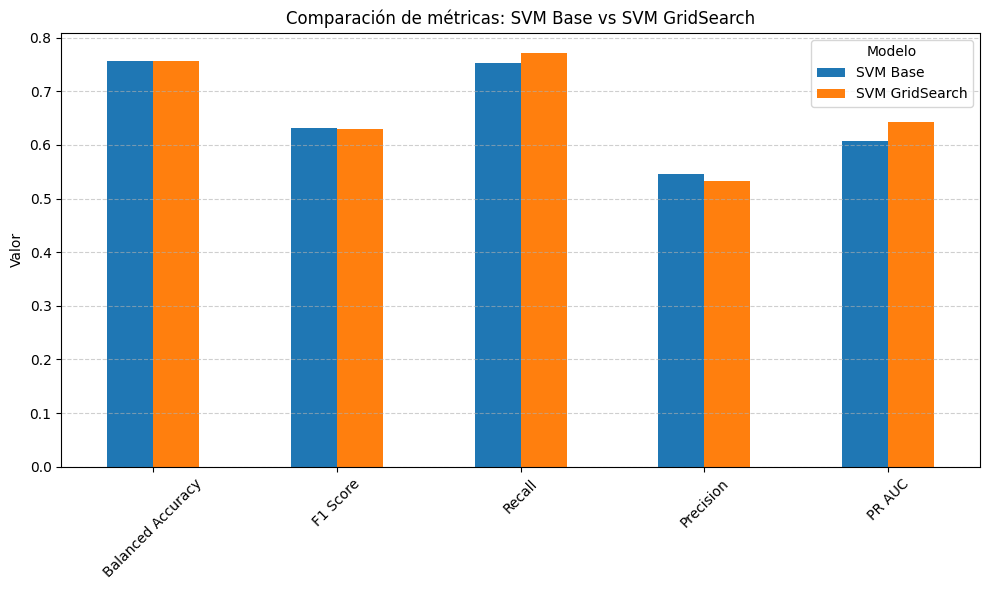

In [35]:
# Extraer métricas del modelo final (entrenado con GridSearchCV)
metricas_final = {
    'Balanced Accuracy': balanced_acc_final,
    'F1 Score': f1_final,
    'Recall': recall_final,
    'Precision': precision_final,
    'PR AUC': pr_auc_final
}

# Extraer métricas del modelo base SVM_rbf estandarizado (de df_resultados_std)
# Buscamos la fila correspondiente al modelo 'STD - SVM_rbf'
metricas_base_row = df_resultados_std[df_resultados_std['Modelo'] == 'STD - SVM_rbf'].iloc[0]
metricas_base = {
    'Balanced Accuracy': metricas_base_row['Balanced Accuracy'],
    'F1 Score': metricas_base_row['F1 Score'],
    'Recall': metricas_base_row['Recall'],
    'Precision': metricas_base_row['Precision'],
    'PR AUC': metricas_base_row['PR AUC']
}

# Mostrar las métricas exactas en formato tabla
df_metricas = pd.DataFrame([metricas_base, metricas_final], index=['SVM Base', 'SVM GridSearch'])
print("Métricas exactas de cada modelo:")
print(df_metricas)

# Crear DataFrame para comparar
import matplotlib.pyplot as plt

df_comparacion = pd.DataFrame([metricas_base, metricas_final], index=['SVM Base', 'SVM GridSearch'])

# Plot
df_comparacion.T.plot(kind='bar', figsize=(10,6))
plt.title('Comparación de métricas: SVM Base vs SVM GridSearch')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.legend(title='Modelo')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Mejores hiperparámetros encontrados por Random Search: {'gamma': 0.1, 'class_weight': 'balanced', 'C': 1}
Mejor Balanced Accuracy en CV (Random Search): 0.7643298945240116


<Figure size 1200x600 with 0 Axes>

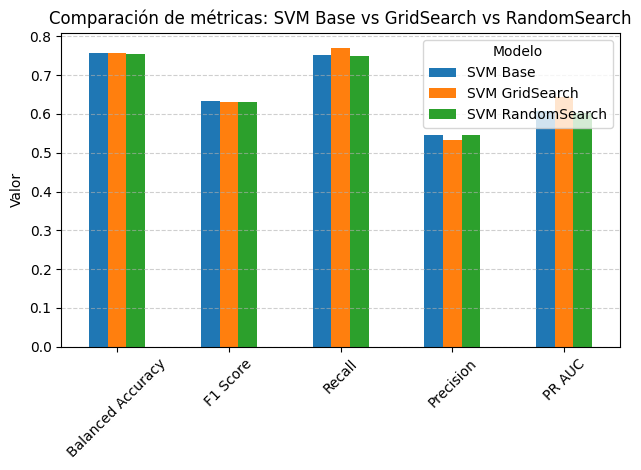

In [36]:
from sklearn.model_selection import RandomizedSearchCV

# Define el espacio de búsqueda para los hiperparámetros del SVM
param_distributions = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
    'class_weight': ['balanced']
}

# Inicializa el modelo SVM
svm_model_rs = SVC(kernel='rbf', random_state=42)

# Búsqueda aleatoria con validación cruzada
random_search = RandomizedSearchCV(
    estimator=svm_model_rs,
    param_distributions=param_distributions,
    n_iter=20,                           # Número de combinaciones a probar
    scoring='balanced_accuracy',
    n_jobs=multiprocessing.cpu_count() - 1,
    cv=cv_strategy,
    refit=True,
    verbose=2,
    random_state=42,
    return_train_score=True
)

# Realizar la búsqueda aleatoria
random_search.fit(X_train_scaled, y_train)

# Mostrar resultados
print("\nMejores hiperparámetros encontrados por Random Search:", random_search.best_params_)
print("Mejor Balanced Accuracy en CV (Random Search):", random_search.best_score_)

# Evaluar el mejor modelo en el conjunto de prueba
y_pred_random = random_search.predict(X_test_scaled)

# Calcular métricas
balanced_acc_random = balanced_accuracy_score(y_test, y_pred_random)
f1_random = f1_score(y_test, y_pred_random)
recall_random = recall_score(y_test, y_pred_random)
precision_random = precision_score(y_test, y_pred_random)

# Calcular PR AUC
if hasattr(random_search.best_estimator_, "decision_function"):
    y_score_random = random_search.best_estimator_.decision_function(X_test_scaled)
    pr_auc_random = average_precision_score(y_test, y_score_random)

# Crear DataFrame con todas las métricas para comparar
metricas_random = {
    'Balanced Accuracy': balanced_acc_random,
    'F1 Score': f1_random,
    'Recall': recall_random,
    'Precision': precision_random,
    'PR AUC': pr_auc_random
}

# Comparar los tres modelos
df_comparacion_final = pd.DataFrame([
    metricas_base,
    metricas_final,
    metricas_random
], index=['SVM Base', 'SVM GridSearch', 'SVM RandomSearch'])

# Visualizar comparación
plt.figure(figsize=(12,6))
df_comparacion_final.T.plot(kind='bar')
plt.title('Comparación de métricas: SVM Base vs GridSearch vs RandomSearch')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.legend(title='Modelo')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


###Predicción y Evaluación del modelo

###Predicción de Probabilidades

*En caso de usar un modelo de ensamble, tambien podemos obtener la probabilidad que asigna el árbol de que un valor pertenezca a una clase u otra.*

In [37]:
#...

###Importancia de Predictores

In [38]:
#...

# Extra data

In [39]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7043 non-null   int64  
 1   SeniorCitizen                          7043 non-null   int64  
 2   Partner                                7043 non-null   int64  
 3   Dependents                             7043 non-null   int64  
 4   tenure                                 7043 non-null   int64  
 5   PhoneService                           7043 non-null   int64  
 6   PaperlessBilling                       7043 non-null   int64  
 7   MonthlyCharges                         7043 non-null   float64
 8   TotalCharges                           7043 non-null   float64
 9   Churn                                  7043 non-null   int64  
 10  HasMultipleLines                       7043 non-null   int64  
 11  HasO

In [40]:
# Crear una copia del DataFrame final
df_final_features = df_final.copy()

# Crear columna HasInternet: 1 si tiene cualquier tipo de internet, 0 si no
if 'InternetService_No' in df_final_features.columns:
    df_final_features['HasInternet'] = 1 - df_final_features['InternetService_No']
else:
    # Si no existe la dummy, chequea por las otras
    df_final_features['HasInternet'] = (
        (df_final_features.get('InternetService_Fiber optic', 0) == 1) |
        (df_final_features.get('InternetService_DSL', 0) == 1)
    ).astype(int)

# Definir las columnas de servicios (ajusta los nombres si es necesario)
servicio_cols = [
    'PhoneService',           # Servicio telefónico
    'HasMultipleLines',       # Línea telefónica adicional
    'HasOnlineSecurity',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupport',
    'HasStreamingTV',
    'HasStreamingMovies'
]

# Si alguna columna no existe, ignórala (por si cambió el pipeline)
servicio_cols = [col for col in servicio_cols if col in df_final_features.columns]

# Crear la variable countServices
df_final_features['countServices'] = df_final_features[servicio_cols].sum(axis=1)

# Crear la variable MonthlyChargeRate (evitar división por cero)
df_final_features['MonthlyChargeRate'] = df_final_features['TotalCharges'] / df_final_features['tenure'].replace(0, np.nan)

# Reemplazar posibles infinitos o NaN por 0 (opcional, según tu criterio)
df_final_features['MonthlyChargeRate'] = df_final_features['MonthlyChargeRate'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Estandarizar las variables numéricas (incluyendo las nuevas)
cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges', 'countServices', 'MonthlyChargeRate']

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_final_features_scaled = df_final_features.copy()
df_final_features_scaled[cols_to_scale] = scaler.fit_transform(df_final_features[cols_to_scale])

# Ahora puedes usar df_final_features_scaled para entrenar un modelo
# Ejemplo de split:
from sklearn.model_selection import train_test_split

X = df_final_features_scaled.drop(columns='Churn')
y = df_final_features_scaled['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [41]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.svm import SVC
import multiprocessing

# Define el espacio de búsqueda para los hiperparámetros
param_grid_svm = {
    'C': [0.1, 1, 10, 100],          
    'gamma': [0.001, 0.01, 0.1, 1],  
    'class_weight': ['balanced']      
}

# Inicializa el modelo base
svm_model = SVC(kernel='rbf', random_state=42)

# Define la estrategia de validación cruzada
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=1, random_state=123)

# Configura el GridSearch
grid_svm = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid_svm,
    scoring='balanced_accuracy',
    n_jobs=multiprocessing.cpu_count() - 1,
    cv=cv_strategy,
    refit=True,
    verbose=2,
    return_train_score=True
)

# Realizar la búsqueda usando tus variables de split
grid_svm.fit(X=X_train, y=y_train)

# Mostrar mejores resultados
print("\nMejores hiperparámetros:", grid_svm.best_params_)
print("Mejor Balanced Accuracy en CV:", grid_svm.best_score_)

# Obtener el mejor modelo y evaluar en test
modelo_final = grid_svm.best_estimator_
y_pred = modelo_final.predict(X_test)

# Calcular métricas finales
balanced_acc = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
pr_auc = average_precision_score(y_test, modelo_final.decision_function(X_test))

print("\nMétricas en test:")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}") 
print(f"Precision: {precision:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Mejores hiperparámetros: {'C': 1, 'class_weight': 'balanced', 'gamma': 0.01}
Mejor Balanced Accuracy en CV: 0.7632754395344961

Métricas en test:
Balanced Accuracy: 0.7524
F1 Score: 0.6259
Recall: 0.7664
Precision: 0.5290
PR AUC: 0.6445


In [42]:
from sklearn.model_selection import RandomizedSearchCV

# Define el espacio de búsqueda para los hiperparámetros 
param_distributions = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1], 
    'class_weight': ['balanced']
}

# Inicializa el modelo base
svm_model_rs = SVC(kernel='rbf', random_state=42)

# Configura el RandomSearch
random_search = RandomizedSearchCV(
    estimator=svm_model_rs,
    param_distributions=param_distributions,
    n_iter=20,                           # Número de combinaciones a probar
    scoring='balanced_accuracy',
    n_jobs=multiprocessing.cpu_count() - 1,
    cv=cv_strategy,
    refit=True,
    verbose=2,
    random_state=42,
    return_train_score=True
)

# Realizar la búsqueda usando tus variables
random_search.fit(X_train, y_train)

# Mostrar resultados
print("\nMejores hiperparámetros encontrados:", random_search.best_params_)
print("Mejor Balanced Accuracy en CV:", random_search.best_score_)

# Evaluar el mejor modelo en test
y_pred_random = random_search.predict(X_test)

# Calcular métricas
balanced_acc_random = balanced_accuracy_score(y_test, y_pred_random)
f1_random = f1_score(y_test, y_pred_random)
recall_random = recall_score(y_test, y_pred_random)
precision_random = precision_score(y_test, y_pred_random)

# Calcular PR AUC
if hasattr(random_search.best_estimator_, "decision_function"):
    y_score_random = random_search.best_estimator_.decision_function(X_test)
    pr_auc_random = average_precision_score(y_test, y_score_random)

print("\nMétricas en test:")
print(f"Balanced Accuracy: {balanced_acc_random:.4f}")
print(f"F1 Score: {f1_random:.4f}")
print(f"Recall: {recall_random:.4f}")
print(f"Precision: {precision_random:.4f}")
print(f"PR AUC: {pr_auc_random:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Mejores hiperparámetros encontrados: {'gamma': 0.1, 'class_weight': 'balanced', 'C': 0.1}
Mejor Balanced Accuracy en CV: 0.7628584944487281

Métricas en test:
Balanced Accuracy: 0.7528
F1 Score: 0.6276
Recall: 0.7561
Precision: 0.5363
PR AUC: 0.6216


In [43]:
# --- ENTRENAMIENTO Y COMPARACIÓN SVM-RBF GRIDSEARCH: SIN y CON VARIABLES NUEVAS ---

from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, f1_score, recall_score, precision_score, average_precision_score
import multiprocessing
import pandas as pd

# 1. Definir hiperparámetros y CV
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'class_weight': ['balanced']
}
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=1, random_state=123)

# 2. Entrenamiento SIN variables nuevas
# (Asegúrate de tener X_train_scaled, X_test_scaled, y_train, y_test definidos)
svm_model = SVC(kernel='rbf', random_state=42)
grid_svm_old = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid_svm,
    scoring='balanced_accuracy',
    n_jobs=multiprocessing.cpu_count() - 1,
    cv=cv_strategy,
    refit=True,
    verbose=2,
    return_train_score=True
)
grid_svm_old.fit(X_train_scaled, y_train)
y_pred_old = grid_svm_old.best_estimator_.predict(X_test_scaled)
metrics_old = {
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_old),
    'F1 Score': f1_score(y_test, y_pred_old),
    'Recall': recall_score(y_test, y_pred_old),
    'Precision': precision_score(y_test, y_pred_old),
    'PR AUC': average_precision_score(y_test, grid_svm_old.best_estimator_.decision_function(X_test_scaled))
}

# 3. Entrenamiento CON variables nuevas
# (Asegúrate de tener X_train, X_test, y_train, y_test con las variables nuevas y escaladas)
svm_model2 = SVC(kernel='rbf', random_state=42)
grid_svm_new = GridSearchCV(
    estimator=svm_model2,
    param_grid=param_grid_svm,
    scoring='balanced_accuracy',
    n_jobs=multiprocessing.cpu_count() - 1,
    cv=cv_strategy,
    refit=True,
    verbose=2,
    return_train_score=True
)
grid_svm_new.fit(X_train, y_train)
y_pred_new = grid_svm_new.best_estimator_.predict(X_test)
metrics_new = {
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_new),
    'F1 Score': f1_score(y_test, y_pred_new),
    'Recall': recall_score(y_test, y_pred_new),
    'Precision': precision_score(y_test, y_pred_new),
    'PR AUC': average_precision_score(y_test, grid_svm_new.best_estimator_.decision_function(X_test))
}

# 4. Mostrar resultados
df_comp = pd.DataFrame([metrics_old, metrics_new], index=['Sin nuevas variables', 'Con nuevas variables'])
print("Comparación de métricas SVM-RBF (GridSearch):")
print(df_comp)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Comparación de métricas SVM-RBF (GridSearch):
                      Balanced Accuracy  F1 Score    Recall  Precision  \
Sin nuevas variables           0.756024  0.630344  0.770492   0.533333   
Con nuevas variables           0.752403  0.625941  0.766393   0.528996   

                        PR AUC  
Sin nuevas variables  0.643403  
Con nuevas variables  0.644507  


                      Balanced Accuracy  F1 Score    Recall  Precision  \
Sin nuevas variables           0.756024  0.630344  0.770492   0.533333   
Con nuevas variables           0.752403  0.625941  0.766393   0.528996   

                        PR AUC  
Sin nuevas variables  0.643403  
Con nuevas variables  0.644507  


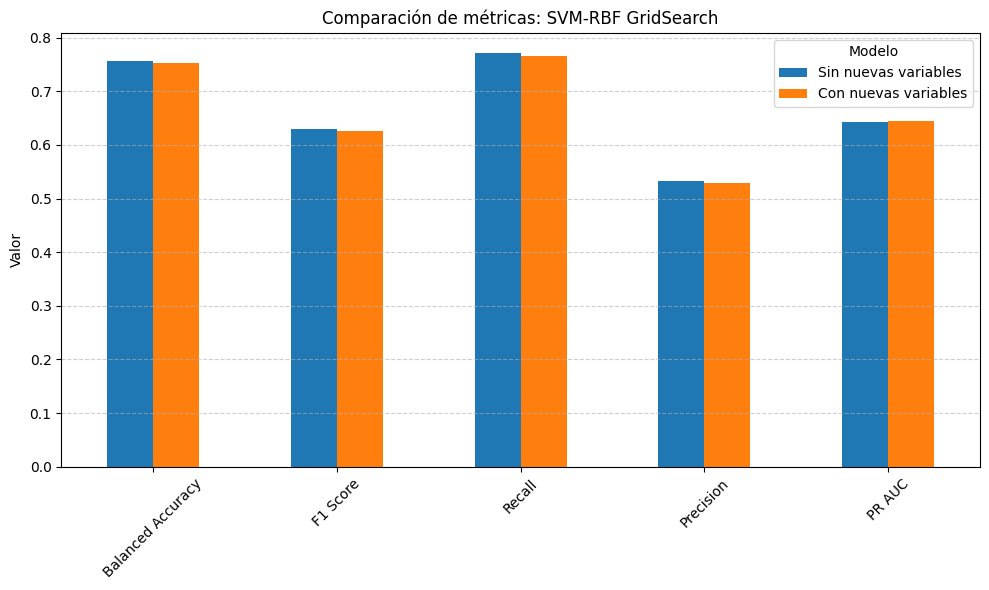

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Supone que ya corriste ambos entrenamientos y tenés las métricas:
# balanced_acc_final, f1_final, recall_final, precision_final, pr_auc_final (sin nuevas variables)
# balanced_acc, f1, recall, precision, pr_auc (con nuevas variables)

# Guardá las métricas en diccionarios
metricas_sin_nuevas = {
    'Balanced Accuracy': balanced_acc_final,
    'F1 Score': f1_final,
    'Recall': recall_final,
    'Precision': precision_final,
    'PR AUC': pr_auc_final
}

metricas_con_nuevas = {
    'Balanced Accuracy': balanced_acc,
    'F1 Score': f1,
    'Recall': recall,
    'Precision': precision,
    'PR AUC': pr_auc
}

# Crear DataFrame comparativo
df_comp = pd.DataFrame([metricas_sin_nuevas, metricas_con_nuevas], 
                       index=['Sin nuevas variables', 'Con nuevas variables'])
print(df_comp)

# Gráfico comparativo
df_comp.T.plot(kind='bar', figsize=(10,6))
plt.title('Comparación de métricas: SVM-RBF GridSearch')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.legend(title='Modelo')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [45]:
# ...existing code...

# Guardar el DataFrame comparativo en un archivo pickle
df_comp.to_pickle("comparacion_metricas_svm_gridsearch.pkl")
print("Archivo guardado: comparacion_metricas_svm_gridsearch.pkl")
# ...existing code...

Archivo guardado: comparacion_metricas_svm_gridsearch.pkl


In [ ]:
#

# ENTRE

In [7]:
df_mod_1 = df_mod.copy()
df_mod_1['HasMultipleLines'] = ((df_mod_1['PhoneService'] == 1) & (df_mod_1['MultipleLines'] == 'Yes')).astype(int)
df_mod_1.drop(columns='MultipleLines', inplace=True)
df_mod_2 = df_mod_1.copy()
# Lista de columnas relacionadas con servicios que dependen de tener Internet
internet_services = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

# Creamos nuevas variables binarias
for col in internet_services:
    new_col = 'Has' + col  # Ej: 'HasOnlineSecurity'
    df_mod_2[new_col] = ((df_mod_2['InternetService'] != 'No') & (df_mod_2[col] == 'Yes')).astype(int)

# Eliminamos columnas originales
df_mod_2.drop(columns=internet_services, inplace=True)
# Transformamos variables categóricas de 3 o más opciones con el método dummy coding.
df_mod_3 = df_mod_2.copy()

# Lista de columnas categóricas a codificar
categorical_cols = ['InternetService', 'Contract', 'PaymentMethod']

# Aplicamos One-Hot Encoding
df_mod_3 = pd.get_dummies(df_mod_3, columns=categorical_cols, drop_first=True)
# Todas las nuevas columnas creadas por el dummy coding son booleanas, las transformamos a numéricas
df_mod_4 = df_mod_3.copy()
bool_cols = df_mod_4.select_dtypes(include='bool').columns
df_mod_4[bool_cols] = df_mod_4[bool_cols].astype(int)
# Reemplazo específico para 'gender'
df_mod_5 = df_mod_4.copy()
df_mod_5['gender'] = df_mod_5['gender'].replace({'Male': 1, 'Female': 0})

# Otras variables categóricas binarias (Yes/No)
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling','Churn']
df_mod_5[binary_cols] = df_mod_5[binary_cols].replace({'Yes': 1, 'No': 0})

# Eliminamos costumerID
df_final = df_mod_5.copy()
df_final.drop(columns='customerID', inplace=True)

C:\Users\Leo\AppData\Local\Temp\ipykernel_15268\2070991846.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mod_5['gender'] = df_mod_5['gender'].replace({'Male': 1, 'Female': 0})
C:\Users\Leo\AppData\Local\Temp\ipykernel_15268\2070991846.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mod_5[binary_cols] = df_mod_5[binary_cols].replace({'Yes': 1, 'No': 0})


In [8]:
# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        df_final.drop(columns = 'Churn'),
                                        df_final['Churn'],
                                        random_state = 22
                                    )

In [9]:
# Variables a escalar
cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Inicializamos el escalador
scaler = StandardScaler()

# Ajustamos el escalador solo con datos de entrenamiento
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [11]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import make_classification

In [12]:
# Hiperparámetros para Grid Search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'class_weight': ['balanced']
}

# Hiperparámetros para Randomized Search
param_distributions = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
    'class_weight': ['balanced']
}

# Inicializamos el clasificador
svm = SVC(kernel='rbf')

# Grid Search con CV
grid_search = GridSearchCV(
    svm, param_grid, scoring='balanced_accuracy', cv=5, n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)

# Randomized Search con CV
random_search = RandomizedSearchCV(
    svm, param_distributions, scoring='balanced_accuracy', cv=5,
    n_iter=10, n_jobs=-1, random_state=42
)
random_search.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'class_weight': ['balanced'],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1]},
                   random_state=42, scoring='balanced_accuracy')

In [13]:
# Evaluación en test
def evaluate_model(model, name):
    y_pred = model.predict(X_test_scaled)
    return {
        'Tuning Method': name,
        'Best Params': model.best_params_,
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }

# Resultados
results = [
    evaluate_model(grid_search, 'GridSearchCV'),
    evaluate_model(random_search, 'RandomizedSearchCV')
]

# Mostrar resultados en un DataFrame
results_df = pd.DataFrame(results)
print(results_df)

        Tuning Method                                        Best Params  \
0        GridSearchCV  {'C': 0.1, 'class_weight': 'balanced', 'gamma'...   
1  RandomizedSearchCV  {'gamma': 0.1, 'class_weight': 'balanced', 'C'...   

   Balanced Accuracy  Precision    Recall  F1 Score  
0           0.746667   0.512445  0.751073  0.609225  
1           0.758698   0.530735  0.759657  0.624890  
